In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)
import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [198]:
def prepare_for_clustering(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, n_samples=1, sample_size=-1, initial_centroids=None, max_iter=300):
    if sample_size == -1:
        sample_size = df.shape[0]

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    
    modelss = [[], []]
    sampless = [[], []]

    for i in range(0, k_max):
        modelss.append([])
        sampless.append([])
        
    for i in range(0, n_samples):
        sample = numeric_df.sample(n=sample_size).copy()
        for k in tqdm(range(k_min, k_max+1)):
            if initial_centroids is None:
                model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
            else:
                model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
            labels = model.fit_predict(sample)

            modelss[k].append(model)
            sampless[k].append(sample)

    return modelss, sampless


def scores(modelss, sampless, k_min, k_max, sample_size=-1, n_samples=1):
    SSEss = []
    separationss = []
    silhouettess = []

    for i in range(0, k_min):
        SSEss.append([])
        separationss.append([])
        silhouettess.append([])
    
    modelss = modelss[k_min:k_max+1]
    sampless = sampless[k_min:k_max+1]

    k = k_min
    for models, samples in zip(modelss, sampless):
        print(f'k = {k}')
        SSEs = []
        separations = []
        silhouettes = []

        for model, sample in zip(models, samples):
            SSEs.append(model.inertia_)
            separations.append(metrics.davies_bouldin_score(sample, model.labels_))
            for j in tqdm(range(0, n_samples)):
                if sample_size == -1:
                    sample_size = len(sample)
                
                sampled_indeces = random.sample(range(len(sample)), sample_size)
                sampled_points = [sample.iloc[i] for i in sampled_indeces]
                sampled_labels = [model.labels_[i] for i in sampled_indeces]

                silhouettes.append(silhouette_score(sampled_points, sampled_labels))
        
        SSEss.append(SSEs)
        separationss.append(separations)
        silhouettess.append(silhouettes)

        k += 1
    
    scoress_dict = {
        'SSE': SSEss,
        'Separation': separationss,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    # Combine items and scores using zip
    combined = list(zip(columns, max_scores))

    # Sort the combined list based on scores in descending order
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)

    # Extract the sorted items
    sorted_cols = [item for item, score in sorted_combined]
    # Extract the sorted scores
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scoress_dict, k_min, k_max):
    #row = 0
    col = 0
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scoress_dict), figsize=(15, 3))#fig, axes = plt.subplots(nrows=len(scoress_dict), ncols=3, figsize=(15, 3*len(scoress_dict)))

    for key in scoress_dict:
        scoress = scoress_dict[key]
        mean_scores = []
        #max_scores = []
        #min_scores = []
        
        for k in k_values:
            mean_scores.append(np.mean(np.array(scoress[k])))
            #max_scores.append(np.max(np.array(scoress[k])))
            #min_scores.append(np.min(np.array(scoress[k])))
        
        axes[col].plot(k_values, mean_scores)
        axes[col].set_title(key)
        axes[col].set_xlabel('Number of clusters')
        axes[col].set_ylabel(key)
        col += 1

    plt.tight_layout()
    plt.show()

    '''
        axes[row, 0].plot(k_values, mean_scores)
        axes[row, 0].set_title('Mean ' + key)
        axes[row, 0].set_xlabel('Number of clusters')
        axes[row, 0].set_ylabel(key)

        axes[row, 1].plot(k_values, max_scores)
        axes[row, 1].set_title('Max ' + key)
        axes[row, 1].set_xlabel('Number of clusters')
        axes[row, 1].set_ylabel(key)

        axes[row, 2].plot(k_values, min_scores)
        axes[row, 2].set_title('Min ' + key)
        axes[row, 2].set_xlabel('Number of clusters')
        axes[row, 2].set_ylabel(key)

        row += 1

    plt.tight_layout()
    plt.show()

    for key in scoress_dict:
        print(f'Max {key}: {np.max(max_scores)} (for k={np.argmax(max_scores)+k_min})')
        print(f'Min {key}: {np.min(min_scores)} (for k={np.argmin(max_scores)+k_min})')
    '''
    return mean_scores#, max_scores, min_scores

In [3]:
df = pd.read_csv('./dataset/data/final_clean2.csv')

df_with_out, df_with_out_s, scaler_with_out = prepare_for_clustering(df, remove_outliers=False, with_indicators=True)
df_no_out, df_no_out_s, scaler_no_out = prepare_for_clustering(df, remove_outliers=True, with_indicators=True)
df_with_out_orig, df_with_out_orig_s, scaler_with_out_orig = prepare_for_clustering(df, remove_outliers=False, with_indicators=False)
df_no_out_orig, df_no_out_orig_s, scaler_no_out_orig = prepare_for_clustering(df, remove_outliers=True, with_indicators=False)

print(f'Dataset dimentions: {df.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, with indicators: {df_with_out.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df_no_out.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, without indicators: {df_with_out_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_no_out_orig.shape}')

Dataset dimentions: (235219, 61)
Dataset dimentions with ouliers, with only numerical cols, with indicators: (235219, 51)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)
Dataset dimentions with ouliers, with only numerical cols, without indicators: (235219, 19)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)


### Original dataset (i.e. dataset without indicators)

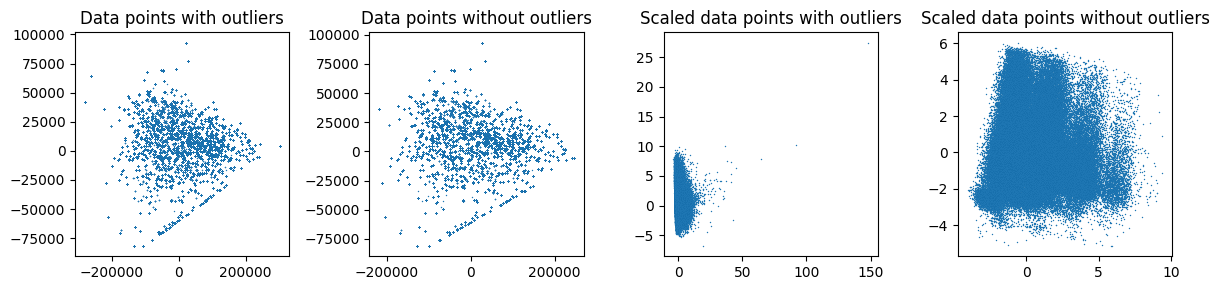

In [4]:
pca_with_out = perform_PCA(df=df_with_out_orig, n_components=2)
pca_no_out = perform_PCA(df=df_no_out_orig, n_components=2)

pca_with_out_s = perform_PCA(df=df_with_out_orig_s, n_components=2)
pca_no_out_s = perform_PCA(df=df_no_out_orig_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_with_out[:, 0], pca_with_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points with outliers')

plt.subplot(1, 4, 2)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.subplot(1, 4, 3)
plt.scatter(pca_with_out_s[:, 0], pca_with_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points with outliers')

plt.subplot(1, 4, 4)
plt.scatter(pca_no_out_s[:, 0], pca_no_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points without outliers')

plt.tight_layout()
plt.show()

### Augmented dataset

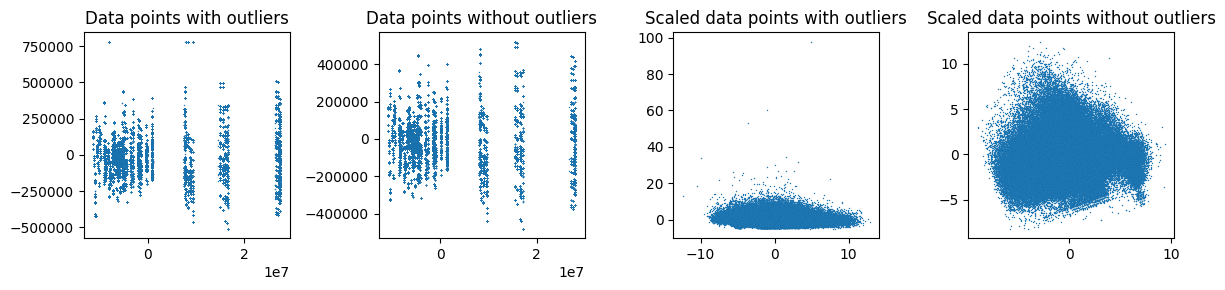

In [5]:
pca_with_out = perform_PCA(df=df_with_out, n_components=2)
pca_no_out = perform_PCA(df=df_no_out, n_components=2)

pca_with_out_s = perform_PCA(df=df_with_out_s, n_components=2)
pca_no_out_s = perform_PCA(df=df_no_out_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_with_out[:, 0], pca_with_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points with outliers')

plt.subplot(1, 4, 2)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.subplot(1, 4, 3)
plt.scatter(pca_with_out_s[:, 0], pca_with_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points with outliers')

plt.subplot(1, 4, 4)
plt.scatter(pca_no_out_s[:, 0], pca_no_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points without outliers')

plt.tight_layout()
plt.show()

# K-means

### K-means experiments on the original dataset (without outliers)

#### K-means on the full original dataset

In [6]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=df_no_out_orig_s, k_min=k_min, k_max=k_max, max_iter=300)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:36<00:00,  4.02s/it]


k = 2


100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


k = 3


100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


k = 4


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 5


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 6


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 7


100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


k = 8


100%|██████████| 3/3 [00:14<00:00,  4.98s/it]


k = 9


100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


k = 10


100%|██████████| 3/3 [00:14<00:00,  4.70s/it]


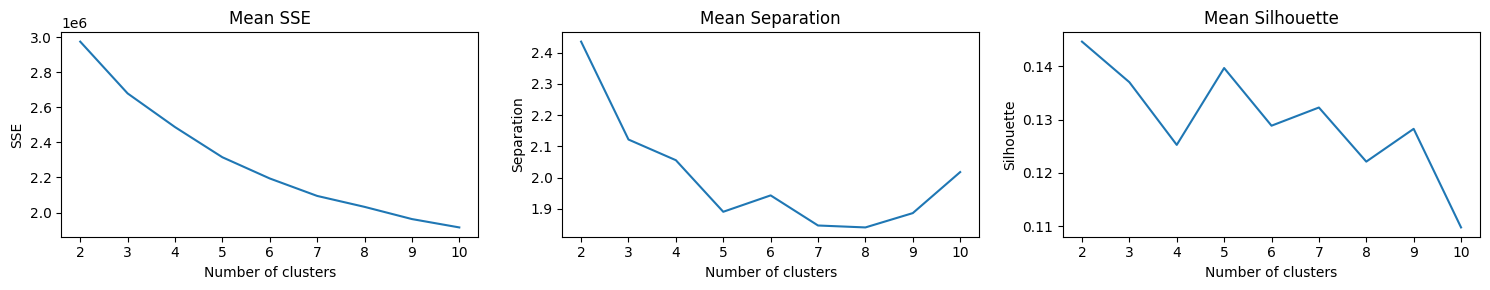

In [48]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [80]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


100%|██████████| 5/5 [00:42<00:00,  8.49s/it]

Best mean score for k = 2:
SSE = 2974152.7060694294
Separation = 2.4354931071492247
Silhouette = 0.14582580217325097


In [129]:
modelss, sampless = k_means(df_no_out_orig_s, k_min=best_k, k_max=best_k, max_iter=1000000)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [91]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:40<00:00,  8.14s/it]


k = 2:
SSE = 2974152.4876594036
Separation = 2.4354415827923126
Silhouette = 0.14672382784231047


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


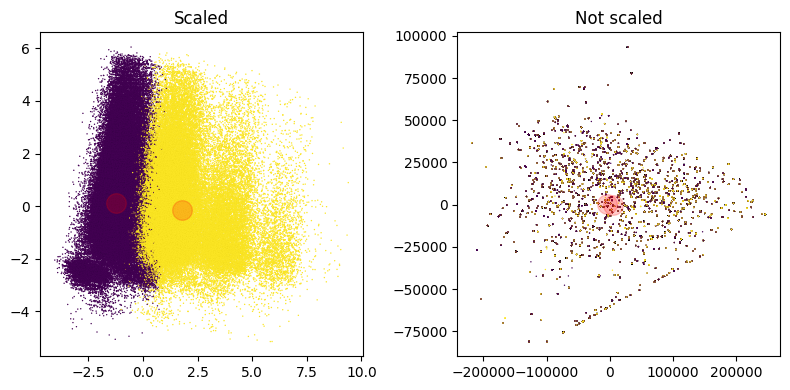

Cluster 0: 112724 points
Cluster 1: 78253 points


In [135]:
best_model = modelss[best_k][0]
best_model_samples = sampless[best_k][0]

points_pca_s, centroids_pca_s = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

orig_points = scaler_no_out_orig.inverse_transform(best_model_samples)
orig_centroids = scaler_no_out_orig.inverse_transform(best_model.cluster_centers_)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

##### Feature reduction using variance:

In [234]:
reduced_no_out_orig_var = features_reduction_var(df_no_out_orig_s, variance_threshold=1)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig_var.columns)}')
print(reduced_no_out_orig_var.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')


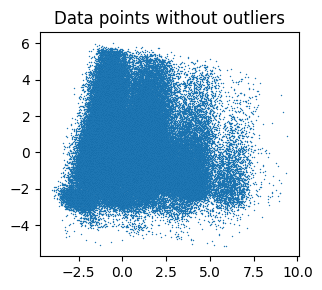

In [235]:
pca_no_out = perform_PCA(df=reduced_no_out_orig_var, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

##### Feature reduction using correlation:

In [263]:
reduced_no_out_orig = features_reduction_corr(reduced_no_out_orig_var, correlation_threshold=0.25)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig.columns)}')
print(reduced_no_out_orig.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


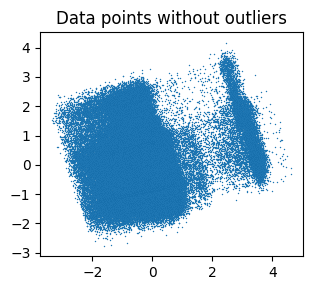

In [264]:
pca_no_out = perform_PCA(df=reduced_no_out_orig, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

#### K-means on the reduced original dataset

In [265]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=reduced_no_out_orig, k_min=k_min, k_max=k_max, max_iter=300)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


k = 5


100%|██████████| 3/3 [00:07<00:00,  2.37s/it]


k = 6


100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


k = 7


100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


k = 9


100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


k = 10


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


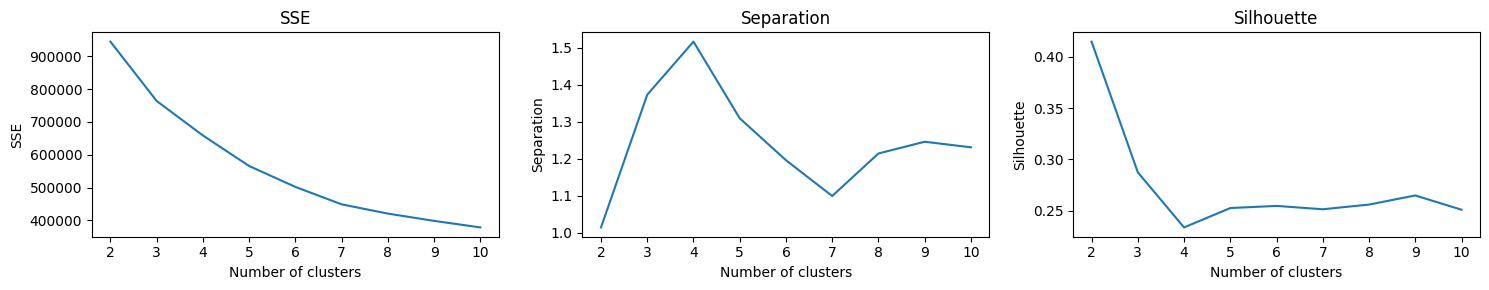

In [266]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [267]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:45<00:00,  9.15s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960042
Separation = 1.0147015718388643
Silhouette = 0.41240124964697833


In [268]:
modelss, sampless = k_means(reduced_no_out_orig, k_min=best_k, k_max=best_k, max_iter=1000000)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


In [269]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


k = 2:
SSE = 944734.0845960032
Separation = 1.0147015718388641
Silhouette = 0.41320856773404246


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


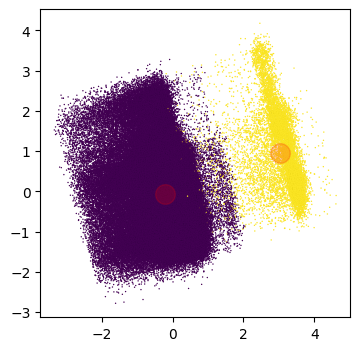

Cluster 0: 177714 points
Cluster 1: 13263 points


In [270]:
best_model = modelss[best_k][0]

best_model_samples = sampless[best_k][0]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

### K-means experiments on the augmented (i.e. with indicators) dataset (without outliers)

#### K-means on the full augmented dataset

In [195]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=df_no_out_s, k_min=k_min, k_max=k_max, max_iter=300)

100%|██████████| 9/9 [01:08<00:00,  7.60s/it]


k = 2


100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


k = 5


100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


k = 6


100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


k = 7


100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


k = 8


100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


k = 9


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


k = 10


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


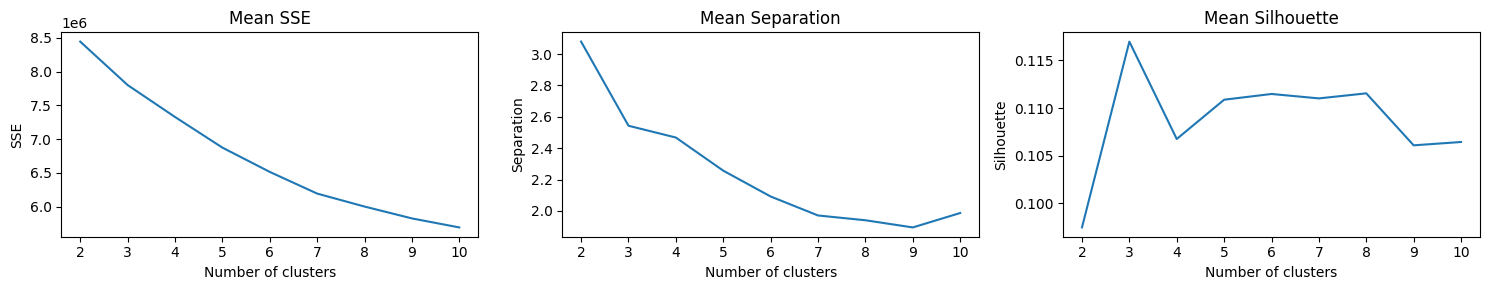

In [196]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [197]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 3


100%|██████████| 5/5 [00:46<00:00,  9.27s/it]


Best mean silhouette score for k = 3:
SSE = 7800452.233258557
Separation = 2.542879662925458
Silhouette = 0.11549977236927748


In [199]:
modelss, sampless = k_means(df_no_out_s, k_min=best_k, k_max=best_k, max_iter=1000000)

100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


In [200]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 3


100%|██████████| 5/5 [00:44<00:00,  8.92s/it]


k = 3:
SSE = 7800442.485924345
Separation = 2.547730292192497
Silhouette = 0.11440340386985974


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


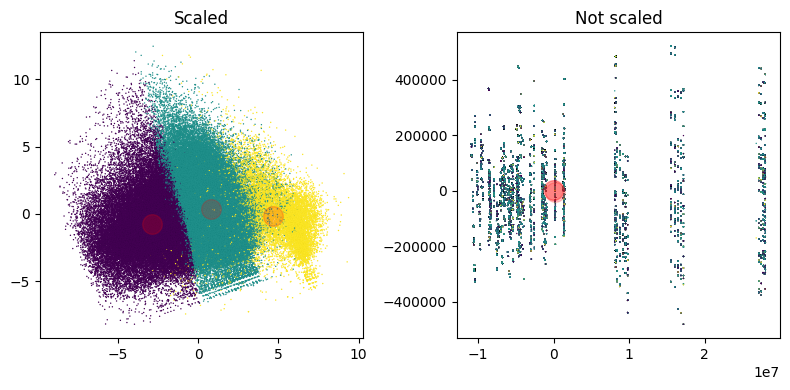

Cluster 0: 53861 points
Cluster 1: 124231 points
Cluster 2: 12885 points


In [202]:
best_model = modelss[best_k][0]
best_model_samples = sampless[best_k][0]

points_pca_s, centroids_pca_s = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

orig_points = scaler_no_out.inverse_transform(best_model_samples)
orig_centroids = scaler_no_out.inverse_transform(best_model.cluster_centers_)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### Feature reduction

In [239]:
reduced_no_out_var = features_reduction_var(df_no_out_s, variance_threshold=1)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_var.columns)}')
print(reduced_no_out_var.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_

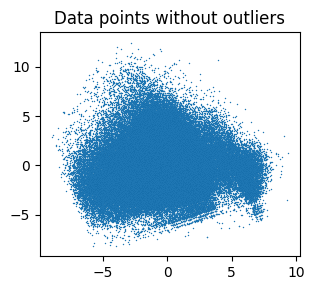

In [204]:
pca_no_out = perform_PCA(df=reduced_no_out_var, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

In [249]:
reduced_no_out = features_reduction_corr(reduced_no_out_var, correlation_threshold=0.25)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out.columns)}')
print(reduced_no_out.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


(the same as with the not augmented dataset)

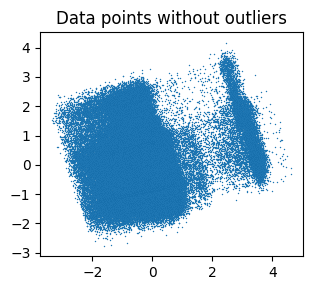

In [250]:
pca_no_out = perform_PCA(df=reduced_no_out, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

In [228]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=reduced_no_out, k_min=k_min, k_max=k_max, max_iter=300)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.78s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


k = 5


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


k = 7


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


k = 9


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


k = 10


100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


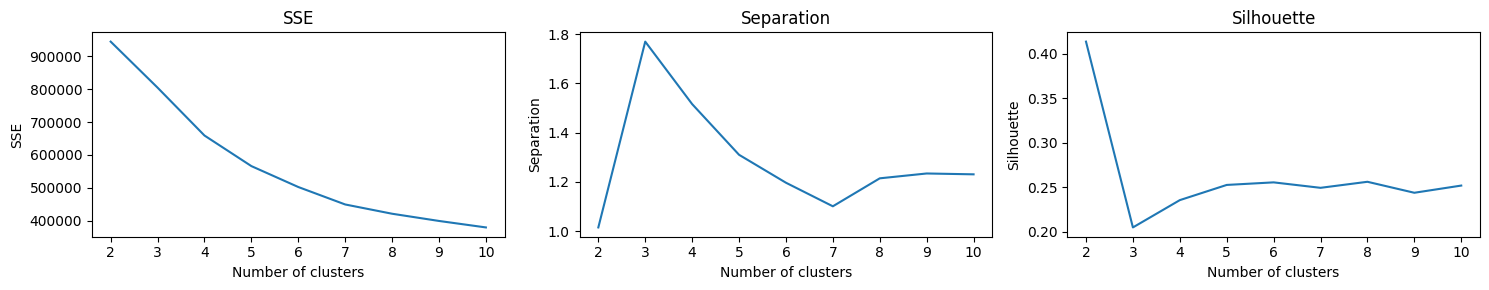

In [229]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [230]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:45<00:00,  9.20s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960062
Separation = 1.0147015718388643
Silhouette = 0.41389858811447056


In [231]:
modelss, sampless = k_means(reduced_no_out, k_min=best_k, k_max=best_k, max_iter=1000000)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


In [232]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:41<00:00,  8.36s/it]


k = 2:
SSE = 944734.0845960078
Separation = 1.0147015718388641
Silhouette = 0.4130000689443271


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


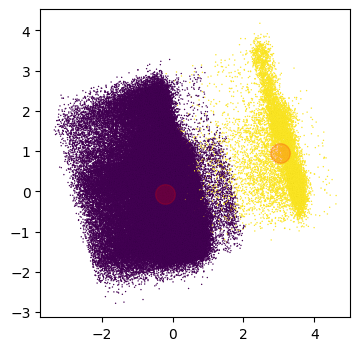

Cluster 0: 177714 points
Cluster 1: 13263 points


In [233]:
best_model = modelss[best_k][0]

best_model_samples = sampless[best_k][0]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

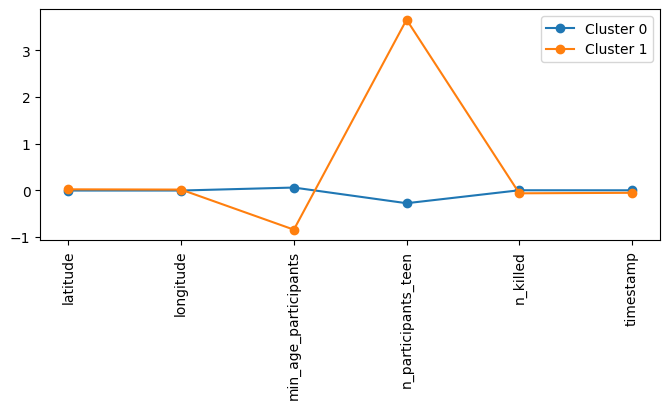

In [318]:
centers = best_model.cluster_centers_
cols = reduced_no_out.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

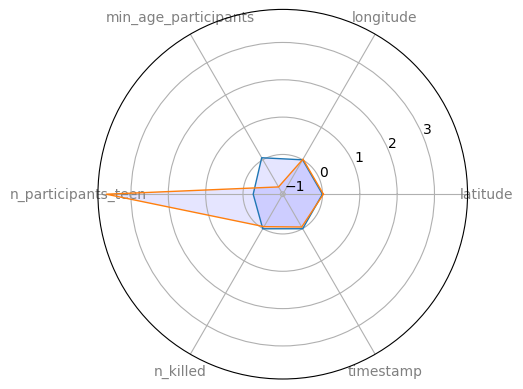

In [289]:
from math import pi

N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [310]:
#TODO: bar charts categorical att.

cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

possible_centers = []
for c in centers:
    for index, row in reduced_no_out.iterrows():
    conditions = (
        (reduced_no_out.iloc[:, :] == pd.DataFrame(centers[i]))
    )
    
    possible_centers.append(reduced_no_out[conditions].mean(axis=0))

'''orig_dfs = []
for df in dfs:
    orig_dfs.append(scaler_no_out.inverse_transform(df))'''

<class 'numpy.ndarray'>


ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

# DBSCAN